# Gold Price Forecasting using LSTM & Hyperparameter Tuning

## Introduction 

This notebook aims to forecast gold prices using various deep learning techinques. Accurate prediction of gold prices is crucial for investors, traders, and financial analysts, as gold is a key commodity in global markets and often considered a safe-haven asset during economic uncertainty.

In this notebook, we implement and optimize a Long Short-Term Memory (LSTM) model to forecast gold prices based on historical data. LSTMs are a type of recurrent neural network particularly suited for time series forecasting, as they are capable of learning temporal dependencies over long sequences.

## Importing Libraries and Packages

In [1]:
# Suppress warning messages for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Libraries for data manipulation and numerical operations
import numpy as np
import pandas as pd

# Libraries for advanced interactive visualizations
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Preprocessing tools and performance metrics for machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error

# TensorFlow and Keras libraries for building deep learning models
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout, LSTM
from keras.optimizers import Adam, Nadam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# Hyperparameter tuning with Keras Tuner
from keras_tuner import Hyperband

## Data Loading

The dataset used in this notebook consists of historical gold prices from the GLD ETF, along with several engineered features created in the `dataprep.py` script. Key features include:

+ **Momentum Indicators** : Various moving averages (e.g., MA3, MA9) and exponential moving averages (e.g., EMA_8).
+ **Volatility Measures** : Rolling standard deviations (e.g., STD_5).
+ **Return Metrics** : Cumulative percentage changes over short periods (e.g., PCT_3).
+ **Additional Indicators** : Related financial instruments such as GDX (Gold Miners ETF), USO (Oil Fund ETF), 10-Year Treasury Yield, and the US Dollar Index (DXY).

This prepared data will be used to build and evaluate predictive models.

In [34]:
# Load the dataset, using 'Date' as the index and parsing the dates correctly
data = pd.read_csv('gold_data.csv', index_col='Date', parse_dates=True)

# Create a list of feature names, selecting all columns starting from the 6th column onward
feature_list = data.columns.tolist()[5:]

In [4]:
# Create an interactive line plot of gold prices over time
fig = px.line(y=data.Close, x=data.index)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')  # Set a custom background color for the plot

## Data Preparation

Before we begin training our models, we need to prepare the data by defining the target variable and splitting the dataset into training and testing sets. We set the target variable as the next day's closing price by shifting the 'Close' column by one day. This allows our models to learn from past prices to predict future prices. We also split the data into training and testing sets, with data prior to 2022 used for training and data after 2022 reserved for testing. Additionally, we perform an 80-20 split within the training data to create a validation set.

In [35]:
# Define the target variable as the next day's closing price by shifting 'Close' column
data['next_day_price'] = data['Close'].shift(-1)

# Remove any rows with missing values resulting from the shift
data = data.dropna()

# Split the data into training features (X) and target variable (y) for dates before 2022
X = data.loc[data.index < '2022-01-01', feature_list]
y = data.loc[data.index < '2022-01-01', 'next_day_price']

# Set aside data after 2022 for testing
test = data[data.index >= '2022-01-01']

In [36]:
# Calculate the 80-20 split point for the training and testing sets
split_point = int(len(X) * 0.8)

# Split the features and target into training (80%) and validation (20%) sets
X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

print("Training Set Size:", X_train.shape, y_train.shape)
print("Testing Set Size:", X_test.shape, y_test.shape)

Training Set Size: (2799, 22) (2799,)
Testing Set Size: (700, 22) (700,)


Finally, we standardize the features using the StandardScaler, ensuring that each feature has a mean of 0 and a variance of 1. This helps improve the performance and convergence of linear machine learning algorithms.

In [37]:
# Initialize MinMaxScaler and scale the training, validation, and external test features
Xscaler = MinMaxScaler()
X_train = Xscaler.fit_transform(X_train)  # Fit and transform the training data
X_test = Xscaler.transform(X_test)  # Transform the test data
test_features = Xscaler.transform(test[feature_list])  # Transform the test features

In [38]:
# Initialize MinMaxScaler for scaling the target variables (y-values)
yscaler = MinMaxScaler()
y_train = yscaler.fit_transform(y_train.values.reshape(-1, 1))  # Fit and scale y_train
y_test = yscaler.transform(y_test.values.reshape(-1, 1))  # Scale y_test without re-fitting
test_target = yscaler.transform(test[['next_day_price']])  # Scale the next_day_price target in the test set

### Time Series Sequences for LSTM

In order to leverage the temporal capabilities of LSTM models, we need to convert our dataset into sequences of data points that the model can learn from. The `create_sequences` function is responsible for transforming our time series data into overlapping sequences of a specified length, where each sequence will be used to predict the next value in the series. This step is crucial for training the LSTM to understand the dependencies and trends in the gold price data over time. We will use this function to prepare both our training and test datasets before feeding them into the model.

In [39]:
def create_sequences(data, target, time_step=1):
    """
    Converts an array of data into sequences for time series prediction.
    
    Objective:
    This function takes in a dataset and creates sequences of data for use in 
    time series forecasting models like LSTMs. It generates sequences of features
    with a specified time step length and aligns the corresponding target values.
    
    Inputs:
    - data: The feature dataset (numpy array) from which sequences are created.
    - target: The target values (numpy array) that correspond to the sequences.
    - time_step: The number of time steps to include in each sequence (default is 1).
    
    Outputs:
    - sequences: A numpy array of sequences, where each sequence is a time step window
      of feature data.
    - targets: A numpy array of corresponding target values aligned with the sequences.
    """
    sequences, targets = [], []
    
	# Loop over the data to create sequences of length 'time_step'
    for i in range(len(data)-time_step+1):
        sequences.append(data[i:(i+time_step), :]) # Extract a sequence of features
        targets.append(target[i + time_step - 1]) # Assign the corresponding target value
        
    return np.array(sequences), np.array(targets)

In [40]:
# Set the time step (sequence length) to 60 days for forecasting future values
time_step = 60  # Using the previous 60 days of data to predict the next value

# Create sequences for training and validation using the defined time step
X_train, y_train = create_sequences(X_train, y_train, time_step)
X_test, y_test = create_sequences(X_test, y_test, time_step)

In [41]:
print("X_train shape:", X_train.shape)  # Expected shape: (num_samples, 60, num_features)
print("y_train shape:", y_train.shape)  # Expected shape: (num_samples,)
print("X_test shape:", X_test.shape)    # Expected shape: (num_samples, 60, num_features)
print("y_test shape:", y_test.shape)    # Expected shape: (num_samples,)

X_train shape: (2740, 60, 22)
y_train shape: (2740, 1)
X_test shape: (641, 60, 22)
y_test shape: (641, 1)


After transforming the data into sequences, we observe the resulting shapes for both the training and validation datasets. The training data, `X_train`, has a shape of (2740, 60, 22), indicating that we have 2,740 sequences, each consisting of 60 time steps and 22 features. Similarly, `X_test` contains 641 sequences, each with the same number of time steps and features. The corresponding target variables, `y_train` and `y_test`, are aligned with these sequences, each holding a single value per sequence. These dimensions confirm that the data is now in the correct format for input into the LSTM model, which expects sequences of time steps with multiple features.

## Model Implementation

### Building LSTM Model

In this section, we define and build our LSTM model architecture for time series forecasting. The model consists of multiple LSTM layers followed by fully connected dense layers. To optimize the model's performance, we use Keras Tuner to dynamically search for the best hyperparameters, including the number of units in each LSTM and dense layer, as well as the optimizer used for training. By fine-tuning these hyperparameters, we aim to build a model that can accurately capture the temporal dependencies in the gold price data while minimizing loss and improving generalization on unseen data.

In [42]:
def build_model(hp):
    """
    Builds a sequential LSTM model with tunable hyperparameters using Keras Tuner.
    
    Objective:
    The function constructs a deep learning model with two LSTM layers followed by
    two fully connected (Dense) layers. The number of units in each layer and the optimizer
    are tuned using Keras Tuner's hyperparameter search.
    
    Inputs:
    - hp: Hyperparameter tuning object from Keras Tuner to specify the search space for
      various parameters (e.g., number of units in LSTM and Dense layers, optimizer choice).
    
    Outputs:
    - model: A compiled Keras Sequential model ready for training.
    """
    
    model = Sequential()
    
    # First LSTM layer with tunable number of units, returning sequences for the next LSTM layer
    model.add(LSTM(
        units=hp.Int('lstm_units_1', min_value=50, max_value=100, step=10),
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    
    # Second LSTM layer with tunable units, no return sequences as this is the final LSTM
    model.add(LSTM(
        units=hp.Int('lstm_units_2', min_value=50, max_value=100, step=10),
        return_sequences=False
    ))

    # First Dense layer with tunable units
    model.add(Dense(
        units=hp.Int('dense_units_1', min_value=16, max_value=64, step=16),
        activation='relu'
    ))

    # Second Dense layer with tunable units
    model.add(Dense(
        units=hp.Int('dense_units_2', min_value=16, max_value=64, step=16),
        activation='relu'
    ))
    
    # Output layer predicting a single value
    model.add(Dense(1))

    # Compile the model with a tunable optimizer and Mean Squared Error loss function
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='mse',
        metrics=['mean_absolute_error']
    )
    
    return model

### Hyperparameter Tuning

To further improve the performance of our LSTM model, we employ **Hyperband**, a powerful method for hyperparameter optimization. Hyperband intelligently allocates resources to different configurations of the model, effectively identifying the best hyperparameters in an efficient manner. By using this technique, we can fine-tune key parameters, such as the number of LSTM units, dense layer sizes, and the choice of optimizer. This process helps us maximize the model's potential while minimizing validation loss. The Hyperband tuner will explore a range of possible configurations and find the optimal model for predicting gold prices.

In [43]:
# Initialize Hyperband tuner for hyperparameter optimization
tuner = Hyperband(
    build_model,  # Function to build the LSTM model with tunable hyperparameters
    objective='val_loss',  # Optimization objective to minimize validation loss
    max_epochs=100,  # Maximum number of epochs for each model during tuning
    hyperband_iterations=2,  # Number of Hyperband iterations for tuning
    directory='Tuning', 
    project_name='GoldLSTM'
)

Reloading Tuner from Tuning/GoldLSTM/tuner0.json


In [ ]:
# Perform the hyperparameter search using the Hyperband tuner
tuner.search(
    X_train, y_train,  # Training data
    epochs=100,  # Maximum number of epochs per model
    batch_size=32,  # Batch size during training
    validation_data=(X_test, y_test),  # Validation data to evaluate performance
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]  # Stop early if no improvement
)

In [46]:
# Retrieve the best model identified by the tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Retrieve and print the best hyperparameters from the tuning process
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

{'lstm_units_1': 90, 'lstm_units_2': 60, 'dense_units_1': 32, 'dense_units_2': 16, 'optimizer': 'adam', 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 4, 'tuner/round': 4, 'tuner/trial_id': '0142'}


Once the hyperparameter tuning process has identified the best-performing model, we proceed to evaluate its performance on the validation data. Using the optimized model, we generate predictions for the unseen validation set and assess its accuracy by calculating the $R^2$ score.

In [47]:
# Use the best model to make predictions on the validation data
y_test_pred = best_model.predict(X_test)

# Calculate and print the R2 score to evaluate the model's performance on the validation set
r2 = r2_score(y_test, y_test_pred)
print(f"R2 Score on Validation Data : {r2}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
R2 Score on Validation Data : 0.9849575688447582


The model achieved an impressive R² score of 0.9849 on the validation data, indicating that it explains approximately 98.5% of the variance in the gold price predictions. This high R² score suggests that the LSTM model, after hyperparameter tuning, has successfully learned the underlying patterns in the time series data, providing accurate predictions on the unseen validation set. The result indicates strong generalization capability, making this model a promising tool for gold price forecasting.

### Best Model Training & Performance

After evaluating the model on the validation data and confirming its strong performance, we now move forward with training the model on the full dataset, which combines both the training and validation data. By leveraging the entire dataset, we allow the model to learn from all available information, maximizing its potential for accurate predictions on the unseen test data. This step is critical as it ensures that the model is fully optimized before we proceed to forecasting future values.

In [48]:
# Concatenate the training and validation feature sets into one dataset
X_all = np.concatenate((X_train, X_test), axis=0)

# Concatenate the training and validation target sets into one dataset
y_all = np.concatenate((y_train, y_test), axis=0)

In [57]:
# Train the best model on the entire training dataset (training + validation) for 100 epochs
best_model.fit(
    X_all, y_all,  # Combined dataset (features and targets)
    epochs=100,  # Maximum number of training epochs
    batch_size=32,  # Batch size for training
    callbacks=[EarlyStopping(monitor='loss', patience=6, restore_best_weights=True)]  # Early stopping to prevent overfitting
)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 2.2463e-04 - mean_absolute_error: 0.0111
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 1.6853e-04 - mean_absolute_error: 0.0096
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 2.5144e-04 - mean_absolute_error: 0.0118
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 2.0023e-04 - mean_absolute_error: 0.0104
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 2.2365e-04 - mean_absolute_error: 0.0114
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 1.9818e-04 - mean_absolute_error: 0.0104
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 2.4361e-04 - mean_absolute_error: 0.0118
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 2.0841e-04 - mean_absolute_error: 0.0108


In preparation for evaluating the model on the final test set, we apply the same sequence creation process used earlier. This involves transforming the test data into sequences of the defined time step, ensuring consistency with the data structure the model was trained on. By reshaping the test set in this way, we enable the model to make accurate predictions based on the historical patterns within these sequences.

In [50]:
# Create sequences for the final test set using the defined time step
test_features, test_target = create_sequences(test_features, test_target, time_step)

print("Shape of Final Testing data :", test_features.shape)
print("Shape of Final Testing target :", test_target.shape)

Shape of Final Testing data : (587, 60, 22)
Shape of Final Testing target : (587, 1)


In [58]:
# Make predictions on the final test data using the best model
y_pred = best_model.predict(test_features)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [59]:
# Compute the R2 score to evaluate the model's performance on the testing set
r2 = r2_score(test_target, y_pred)

print(f"R2 Score on Final Testing Data : {r2}")

R2 Score on Final Testing Data : 0.888253238124502


The model achieved an $R^2$ score of 0.8883 on the final testing data, indicating that it explains approximately 88.8% of the variance in the gold price predictions. While slightly lower than the validation performance, this result still demonstrates that the model generalizes well to new, unseen data. The decrease in the R² score is expected due to the inherent challenge of making predictions on completely unseen data. Nevertheless, this score suggests that the LSTM model remains highly effective in capturing the underlying trends and relationships in the gold price time series.

In [23]:
# Align the date index with the sequences, accounting for the time steps
date_index = test.index[time_step-1:len(test_features)+time_step-1]

# Inverse transform the scaled target and predicted values back to their original scale
test_target = yscaler.inverse_transform(test_target)
y_pred = yscaler.inverse_transform(y_pred)

In [71]:
# Create traces for actual and predicted prices
trace1 = go.Scatter(
    x=date_index,
    y=test_target.flatten(),
    mode='lines',
    name='Actual Prices',
    line=dict(color='blue')
)

trace2 = go.Scatter(
    x=date_index,
    y=y_pred.flatten(),
    mode='lines',
    name='Predicted Prices',
    line=dict(color='red', dash='dash')
)

# Create the layout
layout = go.Layout(
    title='Actual vs. Predicted Prices',
    xaxis=dict(
        title='Date',
        showgrid=True, 
        gridcolor='lightgrey',
        tickformat='%Y-%m',  # Format dates to show year and month
        rangeslider=dict(visible=True)  # Add range slider for zooming
    ),
    yaxis=dict(title='Price'),
    legend=dict(x=0, y=1.1, orientation='h'),
    template='plotly_white'
)

# Create the figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show the figure
fig.show()

In [74]:
# Initialize a Series to hold the predicted values, filled with NaNs initially
y_pred_full = pd.Series(np.full(len(test), np.nan))

# Insert the predicted values starting at the appropriate position (after the time step delay)
start_pos = time_step - 1
y_pred_full.iloc[start_pos:start_pos + len(y_pred)] = y_pred.flatten()

# Forward fill the NaN values to propagate predictions forward
y_pred_full = y_pred_full.fillna(method='ffill')

# Optionally, backward fill any remaining NaN values to cover the initial gaps
y_pred_full = y_pred_full.fillna(method='bfill')

# Inverse transform the predicted values back to their original scale
y_pred_full = yscaler.inverse_transform(y_pred_full.values.reshape(-1, 1)).flatten()

## Trading Strategy Simulation

In this section, we begin implementing a simple trading strategy that leverages the model's forecasted prices. By comparing the model's predicted next-day prices with the actual prices, we generate signals that can guide potential trading actions, such as going long (buy) or holding a position.

The price indicator is calculated based on the difference between the predicted and actual next-day prices. This indicator serves as the core of our trading strategy, providing actionable insights into whether the model anticipates upward or downward price movements.

Once the trading signals are generated, we will later evaluate the performance of this strategy by analyzing some known metrics.

In [77]:
# Create a DataFrame
gold = pd.DataFrame()

# Store actual and predicted prices, along with daily returns
gold['Price'] = test['Close']  # Actual closing price
gold['Predicted_price_next_day'] = y_test_pred  # Model's predicted price for the next day
gold['Actual_price_next_day'] = test['next_day_price']  # Actual price for the next day
gold['Daily Returns'] = gold['Price'].pct_change()  # Calculate daily returns

# Generate a long signal based on price indicators
gold['Price_indicator'] = (test['next_day_price'] - y_test_pred) / test['next_day_price'] * 10

# Display a sample of the data signals
gold.sample(5)

,Price,Predicted_price_next_day,Actual_price_next_day,Daily Returns,Price_indicator
Date,,,,,
2022-11-14,164.919998,163.640118,165.500000,0.002188,0.112380
2023-02-23,169.570007,168.532386,168.350006,-0.000530,-0.010833
2023-10-17,178.289993,175.183882,180.869995,0.001854,0.314376
2024-04-02,210.889999,199.727443,212.740005,0.014772,0.611665
2022-08-04,167.169998,167.803581,165.289993,0.016540,-0.152071


In this trading strategy, we define dynamic thresholds to classify the model's price predictions as undervalued or overvalued. These thresholds help generate trading signals based on the forecasted price movements:

+ **Lower Threshold** (-0.3): When the price indicator falls below this level, the asset is considered undervalued, signaling a potential buy opportunity.
+ **Upper Threshold** (1.0): When the price indicator rises above this level, the asset is considered overvalued, signaling a potential sell or hold decision.

These specific threshold values are not arbitrary. They were chosen with the goal of maximizing the Sharpe ratio, which measures risk-adjusted returns, while also minimizing maximum drawdown, a metric that reflects the largest loss from a peak to a trough in the strategy's performance. This optimization helps ensure that the trading strategy not only delivers profitable returns but also manages risk effectively.

In [109]:
# Plot price and indicator
fig = make_subplots()

# Add the Price Indicator line to the plot
fig.add_trace(go.Scatter(x=gold.index, y=gold['Price_indicator'], mode='lines', name='Price Indicator'))

# Define dynamic thresholds for indicators
lower_threshold = -0.3  # Threshold for Undervalued
upper_threshold = 1   # Threshold for Overvalued

# Add horizontal lines for Neutral, Undervalued, and Overvalued indicators
fig.add_trace(go.Scatter(x=[gold.index.min(), gold.index.max()], y=[0, 0], 
                         mode='lines', line=dict(color='black', dash='dash'), name='Neutral'))

fig.add_trace(go.Scatter(x=[gold.index.min(), gold.index.max()], y=[lower_threshold, lower_threshold], 
                         mode='lines', line=dict(color='green', dash='dash'), name='Undervalued'))

fig.add_trace(go.Scatter(x=[gold.index.min(), gold.index.max()], y=[upper_threshold, upper_threshold], 
                         mode='lines', line=dict(color='red', dash='dash'), name='Overvalued'))

# Update layout with titles and dimensions
fig.update_layout(
    title='Price Indicator Plot',
    xaxis_title='Date',
    yaxis_title='Price Indicator',
    legend_title='Legend',
    autosize=False,
    width=1100,
    height=500
)

# Display the plot
fig.show()

In [108]:
# Implement a Trading Strategy Based on the Price Indicator

# Initialize trading signal and position columns
gold['Trading Signal'] = 0.0  # No initial signals
gold['Position'] = 0  # 1 for long, -1 for short, 0 for no position
gold['Strategy Returns'] = 0.0  # Initialize returns

# Generate trading signals based on price indicators
gold.loc[gold['Price_indicator'] > 1.0, 'Trading Signal'] = -1  # Short signal
gold.loc[gold['Price_indicator'] < -0.3, 'Trading Signal'] = 1  # Long signal

# Shift signals to create positions for the next day
gold['Position'] = gold['Trading Signal'].shift(1)

# Calculate strategy returns based on positions
gold.loc[gold['Position'] == 1, 'Strategy Returns'] = gold['Daily Returns']  # Returns for long positions
gold.loc[gold['Position'] == -1, 'Strategy Returns'] = -gold['Daily Returns']  # Returns for short positions

# Calculate performance metrics: Sharpe ratio and maximum drawdown
strategy_returns = gold['Strategy Returns'].dropna()  # Drop NaN values
sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)  # Annualized Sharpe ratio
max_drawdown = np.max(np.maximum.accumulate(strategy_returns) - strategy_returns)  # Maximum drawdown calculation

# Print the calculated performance metrics
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2f}")

Sharpe Ratio: 0.56
Maximum Drawdown: 0.03


The trading strategy based on the LSTM model's predictions yielded a Sharpe Ratio of 0.56, indicating moderate risk-adjusted returns. A Sharpe Ratio above 0.5 suggests that the strategy is generating returns that are favorable relative to the risk taken, but there is still room for improvement in terms of optimizing risk-reward efficiency. Additionally, the Maximum Drawdown of 0.03 (or 3%) shows that the largest observed loss during the strategy was relatively small, highlighting effective risk management and minimal exposure to significant losses. Overall, these metrics suggest that while the strategy is profitable and relatively low-risk, there may be opportunities to further refine and enhance its performance.

In [110]:
# Plot the strategy returns and equity curve
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)

# First subplot: Gold ETF Price and Strategy Returns
fig.add_trace(go.Scatter(x=gold.index, y=gold['Price'], mode='lines', name='Gold ETF Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=gold.index, y=gold['Price'] * (1 + gold['Strategy Returns'].cumsum().fillna(0)),
                                                          mode='lines', name='Strategy Returns'), row=1, col=1)

# Second subplot: Trading Signal
fig.add_trace(go.Scatter(x=gold.index, y=gold['Trading Signal'], mode='lines', name='Trading Signal'), row=2, col=1)

# Add a horizontal line at y=0 for the Trading Signal
fig.add_trace(go.Scatter(x=gold.index, y=[0,0], 
                         mode='lines', line=dict(color='red', dash='dash'), name='Zero Line'), row=2, col=1)

# Update layout
fig.update_layout(
    title='Gold ETF Price, Strategy Returns, & Trading Signal',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend',
    autosize=False,
    width=1100,
    height=600
)

# Update y-axis titles for each subplot
fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="Trading Signal", row=2, col=1)

# Show the plot
fig.show()

In [111]:
initial_investment = gold['Price'][0]
# Calculate the equity curve based on cumulative strategy returns
equity_curve = gold['Price'] * (1 + gold['Strategy Returns'].cumsum().fillna(0)) / initial_investment * 100

# Create the Plotly figure
fig = go.Figure()

# Add the Equity Curve line to the figure
fig.add_trace(go.Scatter(x=gold.index, y=equity_curve, mode='lines', name='Equity Curve (%)'))

# Update layout for titles and labels
fig.update_layout(
    title='Equity Curve (%)',  # Title of the plot
    xaxis_title='Date',  # X-axis label
    yaxis_title='Equity (%)',  # Y-axis label
    legend_title='Legend',  # Legend title
    autosize=False,  # Disable autosizing
    width=1100,  # Set figure width
    height=600,  # Set figure height
    xaxis=dict(
        showgrid=True,  # Show grid lines on the x-axis
        gridcolor='lightgrey',  # Set grid color
        tickformat='%Y-%m',  # Format dates to show year and month
        rangeslider=dict(visible=True))  # Add a range slider for zooming
)

# Show the plot
fig.show()

                    Strategy
------------------  ----------
Start Period        2022-01-03
End Period          2024-07-30
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   37.35%
CAGR﹪              8.89%

Sharpe              0.89
Prob. Sharpe Ratio  92.38%
Sortino             1.33
Sortino/√2          0.94
Omega               1.16

Max Drawdown        -21.03%
Longest DD Days     632

Gain/Pain Ratio     0.16
Gain/Pain (1M)      1.05

Payoff Ratio        1.05
Profit Factor       1.16
Common Sense Ratio  1.25
CPC Index           0.64
Tail Ratio          1.08
Outlier Win Ratio   3.53
Outlier Loss Ratio  3.48

MTD                 3.49%
3M                  2.93%
6M                  18.15%
YTD                 16.4%
1Y                  22.36%
3Y (ann.)           8.89%
5Y (ann.)           8.89%
10Y (ann.)          8.89%
All-time (ann.)     8.89%

Avg. Drawdown       -3.41%
Avg. Drawdown Days  46
Recovery Factor     1.65
Ulcer Index         0.09
Serenity Index      0.23


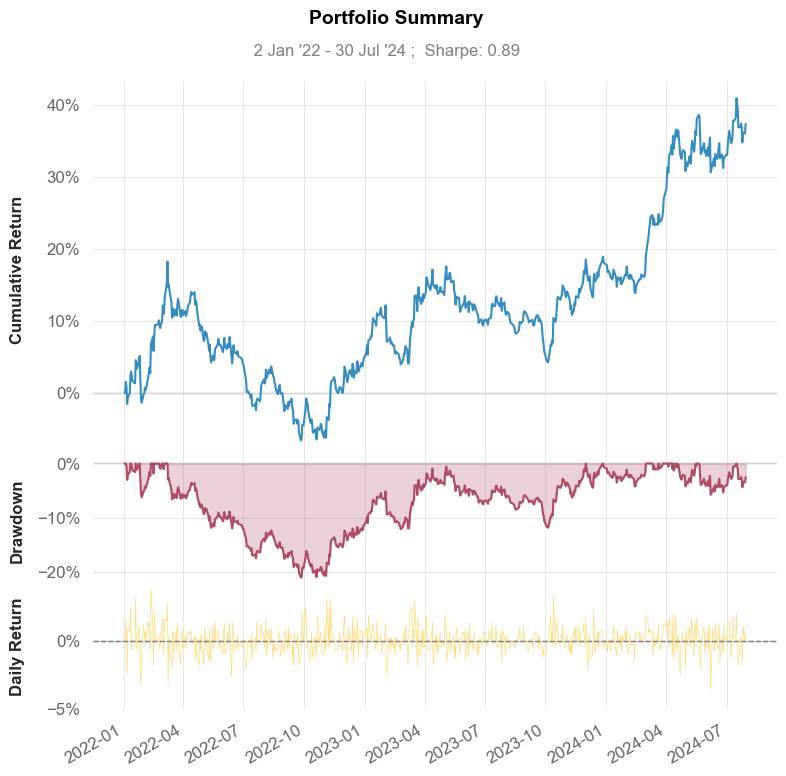

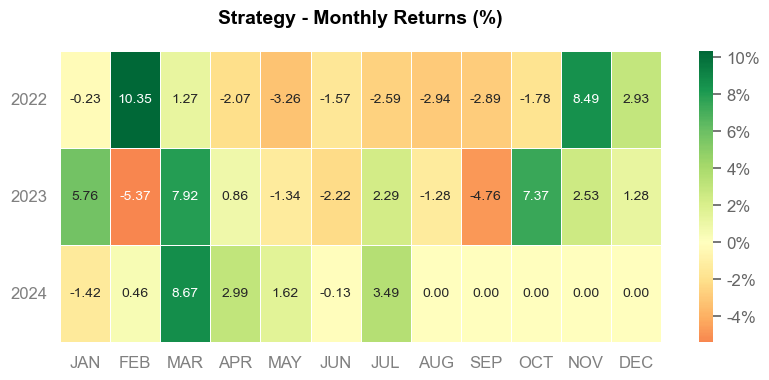

In [112]:
# Performance analysis
import quantstats as qs
# Generate a basic performance report for the equity curve
qs.reports.basic(equity_curve)

# End :)